In [37]:
# Import necessary libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import diffprivlib.models as dp
from sklearn.linear_model import LogisticRegression
from torch import nn, optim
from opacus import PrivacyEngine
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

## Load Training and Testing Data

In [38]:
# Load the data
X_train = pd.read_csv('../../data/X_train.csv', index_col=0)
X_test = pd.read_csv('../../data/X_test.csv', index_col=0)
y_train = pd.read_csv('../../data/y_train.csv', index_col=0)
y_test = pd.read_csv('../../data/y_test.csv', index_col=0)

## Transform Data for the Model

In [39]:
# Check the shapes of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5748, 19), (1437, 19), (5748, 1), (1437, 1))

In [40]:
y_train.head()

,two_year_recid
5355,1
3592,0
29,1
2414,1
5619,1


In [41]:
# Check type of y_train
type(y_train)

pandas.core.frame.DataFrame

In [42]:
# y_train.set_index('Unnamed: 0', inplace=True)
y_train = y_train.squeeze()

# y_test.set_index('Unnamed: 0', inplace=True)
y_test = y_test.squeeze()

In [43]:
# Remove the name of the index
y_train.index.name = None
y_test.index.name = None

In [44]:
# Check type of y_test
type(y_test)

pandas.core.series.Series

In [45]:
y_train.head()

5355    1
3592    0
29      1
2414    1
5619    1
Name: two_year_recid, dtype: int64

In [46]:
y_test.head()

3600    0
4218    0
900     0
5345    1
5682    0
Name: two_year_recid, dtype: int64

In [47]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the training data using the scaler
X_train_scaled = scaler.fit_transform(X_train.drop(['id'], axis=1))
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.drop(['id'], axis=1).columns, index=X_train.index)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test.drop(['id'], axis=1))
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.drop(['id'], axis=1).columns, index=X_test.index)

In [48]:
# Check the shapes of the scaled data
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((5748, 18), (1437, 18), (5748,), (1437,))

In [49]:
# Convert Pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

## Defining a Multi-Layer Perceptron (MLP)

In [50]:
# Set the random seed for reproducibility
torch.manual_seed(10000)

# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,hidden_size3,output_size):
        super(MLPModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size3, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

In [51]:
# Initialize the model, loss function, and optimizer
input_size = X_train_scaled.shape[1]
hidden_size1 = 8
hidden_size2 = 8
hidden_size3 = 4
output_size = 1

In [52]:
model_file_path = "../../model/mlp_model.pth"

# Load the saved model
model = MLPModel(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
model.load_state_dict(torch.load(model_file_path))

<All keys matched successfully>

In [53]:
# Binary Cross Entropy Loss for binary classification
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [54]:
# Convert data to PyTorch DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Comparing Accuracy of Baseline models with Differentially Private models

### 1. Baseline Logistic Regression Model

In [55]:
clf = LogisticRegression(solver="lbfgs", max_iter=1000)
clf.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [56]:
baseline_lr = clf.score(X_test_scaled, y_test)
print("Non-private LR model test accuracy: %.2f%%" % (baseline_lr * 100))

Non-private LR model test accuracy: 69.66%


### 2. Differentially Private Logistic Regression Model

In [57]:
dp_clf = dp.LogisticRegression(random_state=0, epsilon=8.0)
dp_clf.fit(X_train_scaled, y_train)

LogisticRegression(accountant=BudgetAccountant(spent_budget=[(8.0, 0), (4.0, 0), (0.1, 0), (0.5, 0), (1.0, 0), ...]),
                   data_norm=30.479211207303948, epsilon=8.0, random_state=0)

In [58]:
dp_lr = dp_clf.score(X_test_scaled, y_test)
print("Differentially private LR model test accuracy (epsilon=%.2f): %.2f%%" % 
     (dp_clf.epsilon, (dp_lr * 100)))

Differentially private LR model test accuracy (epsilon=8.00): 67.29%


In [59]:
# Decrease epsilon for increased privacy
dp2_clf = dp.LogisticRegression(random_state=0, epsilon=4.0)
dp2_clf.fit(X_train_scaled, y_train)

LogisticRegression(accountant=BudgetAccountant(spent_budget=[(8.0, 0), (4.0, 0), (0.1, 0), (0.5, 0), (1.0, 0), ...]),
                   data_norm=30.479211207303948, epsilon=4.0, random_state=0)

In [60]:
dp2_lr = dp2_clf.score(X_test_scaled, y_test)
print("Differentially private LR model test accuracy (epsilon=%.2f): %.2f%%" % 
     (dp2_clf.epsilon, (dp2_lr * 100)))

Differentially private LR model test accuracy (epsilon=4.00): 66.60%


### 3. Baseline Multi-Layer Percepton

In [61]:
def evaluate_model_accuracy(model, X_test_tensor, y_test_tensor):
    """
    Evaluate the accuracy of a model on a test dataset.

    This function takes a PyTorch model, a tensor of test inputs, and a tensor of test labels,
    and returns the accuracy of the model on the test data. The model's output is assumed to be
    a probability, and the output is thresholded at 0.5 to get the predicted labels.

    Parameters:
    model (torch.nn.Module): The PyTorch model to evaluate.
    X_test_tensor (torch.Tensor): A tensor containing the test inputs.
    y_test_tensor (torch.Tensor): A tensor containing the true labels for the test data.

    Returns:
    float: The accuracy of the model on the test data, as a float between 0 and 1.
    """
    with torch.no_grad():
        model.eval()
        y_pred_prob = model(X_test_tensor)
        y_pred_test = (y_pred_prob >= 0.5).float()
        accuracy = (y_pred_test == y_test_tensor).float().mean()
    return accuracy

In [62]:
baseline_mlp = evaluate_model_accuracy(model, X_test_tensor, y_test_tensor)
print("Non-private MLP model test accuracy: %.2f%%" % (baseline_mlp.item() * 100))

Non-private MLP model test accuracy: 70.49%


### 4. Differentially Private Multi-Layer Perceptron using DP-SGD

In [63]:
model = MLPModel(input_size, hidden_size1, hidden_size2,hidden_size3, output_size)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [64]:
# Define PrivacyEngine parameters
DELTA = 1e-5
EPSILON = 8.0
EPOCHS = 10
MAX_GRAD_NORM = 1.0

In [65]:
# Convert data to PyTorch DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [66]:
def train_model_with_privacy(model, criterion, optimizer, train_loader, num_epochs, DELTA, EPSILON, EPOCHS, MAX_GRAD_NORM):
    """
    Train a PyTorch model with differential privacy.

    This function wraps the model with a PrivacyEngine, which modifies the optimizer to enforce differential privacy.
    It then trains the model for a specified number of epochs, and returns the trained model.

    Parameters:
    model (torch.nn.Module): The PyTorch model to train.
    criterion (torch.nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    train_loader (torch.utils.data.DataLoader): The data loader for the training data.
    num_epochs (int): The number of epochs to train for.
    DELTA (float): The target_delta parameter for the PrivacyEngine.
    EPSILON (float): The target_epsilon parameter for the PrivacyEngine.
    EPOCHS (int): The epochs parameter for the PrivacyEngine.
    MAX_GRAD_NORM (float): The max_grad_norm parameter for the PrivacyEngine.

    Returns:
    torch.nn.Module: The trained model.
    """
    # Wrap the model with PrivacyEngine
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        target_delta=DELTA,
        target_epsilon=EPSILON, 
        epochs=EPOCHS,
        max_grad_norm=MAX_GRAD_NORM,
    )

    # Training loop
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

    return model, privacy_engine

In [67]:
model, privacy_engine = train_model_with_privacy(model, criterion, optimizer, train_loader, num_epochs=3,
                                 DELTA=DELTA, EPSILON=EPSILON, EPOCHS=EPOCHS, MAX_GRAD_NORM=MAX_GRAD_NORM)

Epoch [1/3], Loss: 0.6880483031272888
Epoch [2/3], Loss: 0.6666591167449951
Epoch [3/3], Loss: 0.6233127117156982


In [68]:
dp_mlp = evaluate_model_accuracy(model, X_test_tensor, y_test_tensor)
print("Differentially private MLP model test accuracy (epsilon=%.2f): %.2f%%" % 
      (EPSILON, (dp_mlp.item() * 100)))

Differentially private MLP model test accuracy (epsilon=8.00): 65.14%


In [69]:
# Define new PrivacyEngine parameters for increased privacy
DELTA = 1e-5
EPSILON = 4.0  # Decrease epsilon for more privacy
EPOCHS = 10
MAX_GRAD_NORM = 0.5  # Decrease max_grad_norm for more privacy

In [70]:
model = MLPModel(input_size, hidden_size1, hidden_size2,hidden_size3, output_size)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model2 = train_model_with_privacy(model, criterion, optimizer, train_loader, num_epochs=3,
                                 DELTA=DELTA, EPSILON=EPSILON, EPOCHS=EPOCHS, MAX_GRAD_NORM=MAX_GRAD_NORM)

Epoch [1/3], Loss: 0.6738815307617188
Epoch [2/3], Loss: 0.6914243698120117
Epoch [3/3], Loss: 0.6762195229530334


In [71]:
dp2_mlp = evaluate_model_accuracy(model, X_test_tensor, y_test_tensor)
print("Differentially private MLP model test accuracy (epsilon=%.2f): %.2f%%" % 
      (EPSILON, (dp2_mlp.item() * 100)))

Differentially private MLP model test accuracy (epsilon=4.00): 54.98%


### Comparing accuracy of both models at different values of epsilon

Epoch [1/5], Loss: 0.6727044582366943
Epoch [2/5], Loss: 0.6980343461036682
Epoch [3/5], Loss: 0.657630443572998
Epoch [4/5], Loss: 0.7040789723396301
Epoch [5/5], Loss: 0.6763880252838135
Epoch [1/5], Loss: 0.6959038376808167
Epoch [2/5], Loss: 0.7102382183074951
Epoch [3/5], Loss: 0.7199780344963074
Epoch [4/5], Loss: 0.7466662526130676
Epoch [5/5], Loss: 0.7546866536140442
Epoch [1/5], Loss: 0.7181369066238403
Epoch [2/5], Loss: 0.7038739919662476
Epoch [3/5], Loss: 0.6832300424575806
Epoch [4/5], Loss: 0.6998595595359802
Epoch [5/5], Loss: 0.6761178970336914
Epoch [1/5], Loss: 0.6688907146453857
Epoch [2/5], Loss: 0.8059768676757812
Epoch [3/5], Loss: 0.890235424041748
Epoch [4/5], Loss: 0.6893787384033203
Epoch [5/5], Loss: 0.8057140111923218
Epoch [1/5], Loss: 0.6968284249305725
Epoch [2/5], Loss: 0.6922926306724548
Epoch [3/5], Loss: 0.7034298181533813
Epoch [4/5], Loss: 0.7277949452400208
Epoch [5/5], Loss: 0.6572192907333374
Epoch [1/5], Loss: 0.6867803931236267
Epoch [2/5], L

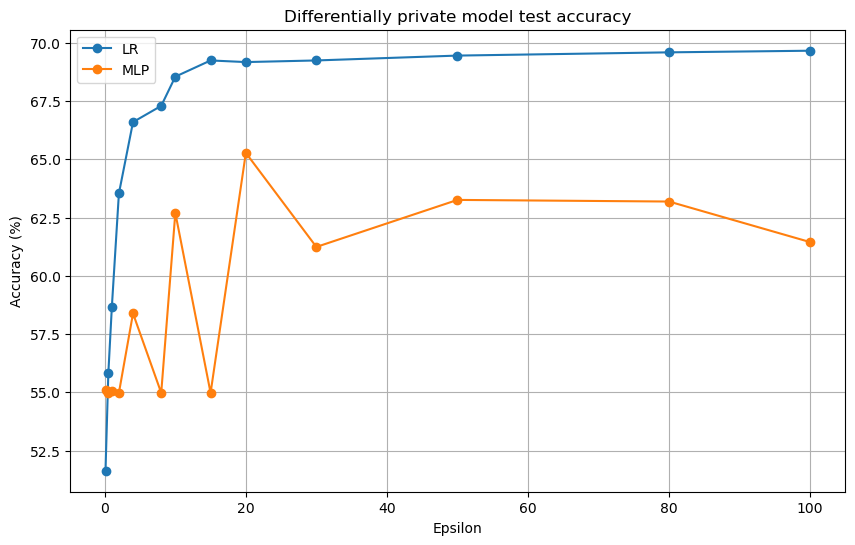

In [74]:
# Define the range of epsilon values
epsilons = [0.1, 0.5, 1.0, 2.0, 4.0, 8.0, 10.0, 15.0, 20.0, 30.0, 50.0, 80.0, 100.0]

# Initialize lists to store results
accuracy_scores_lr = []
accuracy_scores_mlp = []

# Loop over epsilon values
for epsilon in epsilons:
    # Train and evaluate the LR model
    dp_clf = dp.LogisticRegression(random_state=0, epsilon=epsilon)
    dp_clf.fit(X_train_scaled, y_train)
    dp_lr = dp_clf.score(X_test_scaled, y_test)
    accuracy_scores_lr.append(dp_lr * 100)

    # Train and evaluate the MLP model
    model = MLPModel(input_size, hidden_size1, hidden_size2,hidden_size3, output_size)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    model, privacy_engine = train_model_with_privacy(model, criterion, optimizer, train_loader, num_epochs=5,
                                     DELTA=DELTA, EPSILON=epsilon, EPOCHS=EPOCHS, MAX_GRAD_NORM=MAX_GRAD_NORM)
    dp_mlp = evaluate_model_accuracy(model, X_test_tensor, y_test_tensor)
    accuracy_scores_mlp.append(dp_mlp.item() * 100)

    # Explicitly delete the model and privacy engine to ensure they are reset
    del model
    del privacy_engine

# Plot accuracy as a function of epsilon
plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracy_scores_lr, marker='o', label='LR')
plt.plot(epsilons, accuracy_scores_mlp, marker='o', label='MLP')
plt.title('Differentially private model test accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

# Save the plot
plt.savefig('model_accuracy.png')
plt.show()